In [1]:
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

import torch
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [29]:
# load dataset
df = pd.read_csv(open('./data/diva/processed_diva.csv'))
df = df.drop(np.where(np.prod(~df.isnull().values,axis=1)==0)[0])
df.COD_STATO_DOC = df.COD_STATO_DOC.values.astype(str)
df = df.reset_index(drop=True)
y = (df.CNR_S_AND_EXT_Obi==3)+0
df = df.drop('CNR_S_AND_EXT_Obi',axis=1)

drop = []
continuous = []
categorical = []

for i in df.columns:
    if len(df.loc[:,i].unique())>110:
        continuous.append(i)
    elif len(df.loc[:,i].unique())==1:
        drop.append(i)
    else:
        categorical.append(i)

strings = ['cod_uff_prov_gen','cod_uff_ann_gen','INNESCO','TIPOLOGIA_CON','SETT_IMP','COD_MOD_DICH','COD_STATO_DOC']
for s in strings:
    categorical.remove(s)

df = df.drop(drop,axis=1)

from sklearn import preprocessing

cont_df = df.loc[:,continuous]
cont_df = preprocessing.RobustScaler().fit_transform(cont_df)
min_max_scaler = preprocessing.MinMaxScaler([-1,1])
cont_df = min_max_scaler.fit_transform(cont_df)
cont_df = pd.DataFrame(cont_df,columns=continuous)
cat_num_df = df.loc[:,categorical]
hot_enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
hot_enc.fit(cat_num_df)
for i in range(len(cat_num_df.columns)):
    for j in range(len(hot_enc.categories_[i])):
        names.append(cat_num_df.columns[i]+'_'+str(hot_enc.categories_[i][j]))
cat_num_df[names]=hot_enc.transform(cat_num_df).toarray().astype(int)
cat_num_df = cat_num_df.drop(categorical,axis=1)

cat_str_df = df.loc[:,strings]
hot_enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
hot_enc.fit(cat_str_df)
names = []
for i in range(len(cat_str_df.columns)):
    for j in range(len(hot_enc.categories_[i])):
        names.append(cat_str_df.columns[i]+'_'+str(hot_enc.categories_[i][j]))
cat_str_df[names]=hot_enc.transform(cat_str_df).toarray().astype(int)
cat_str_df = cat_str_df.drop(strings,axis=1)
df = pd.concat([cont_df,cat_num_df,cat_str_df],axis=1)

In [30]:
cat_num_df.shape

(12097, 225)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df, y, test_size=0.33, random_state=random_seed)

(array([8726.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3371.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

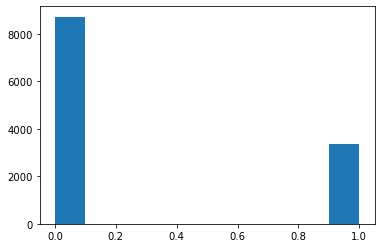

In [32]:
plt.hist(y)

XGB
train acc: 0.9993830207305034
test acc: 0.927122464312547
RF
train acc: 0.9998766041461007
test acc: 0.9048334585524668
SVC
train acc: 0.8547630799605134
test acc: 0.851740545955422


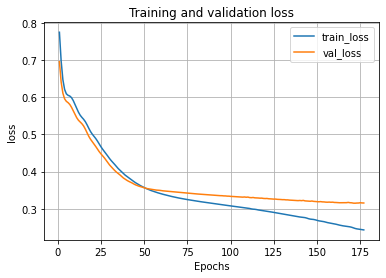

NN
0.907329713721619
0.8657650889055848


In [33]:
# XGB
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, Y_train)
clf_xgb.save_model(f'./blackboxes/diva_xgboost')
clf_xgb.load_model(f'./blackboxes/diva_xgboost')
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)
print('XGB')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#RF
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(min_samples_split=3,random_state=random_seed)
clf_rf.fit(X_train, Y_train)
pickle.dump(clf_rf,open(f'./blackboxes/diva_rf.p','wb'))
clf_rf = pickle.load(open(f'./blackboxes/diva_rf.p','rb'))
y_train_pred = clf_rf.predict(X_train)
y_test_pred = clf_rf.predict(X_test)
print('RF')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#SVC
from sklearn import svm
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
clf = svm.LinearSVC(tol=1e-5)
feature_map_nystroem = Nystroem(n_components=500,n_jobs=-1)
feature_map_nystroem.fit(X_train)
clf_svc = Pipeline([('kernel', feature_map_nystroem), ('model', clf)])
clf_svc.fit(X_train, Y_train)
y_train_pred = clf_svc.predict(X_train)
y_test_pred = clf_svc.predict(X_test)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
BATCH_SIZE = 2**13
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(BATCH_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE)
clf_nn = keras.Sequential([
    keras.layers.Dense(units=100, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
    keras.layers.Dense(units=50, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
    keras.layers.Dense(units=1, activation='sigmoid'),
])
early_stopping = EarlyStopping(patience=5)
clf_nn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = clf_nn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0
)
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')
clf_nn.save_weights(f'./blackboxes/diva_tf_nn')
from sklearn.metrics import accuracy_score
clf_nn.load_weights(f'./blackboxes/diva_tf_nn')
clf_nn.trainable = False
print('NN')
print(accuracy_score(np.round(clf_nn.predict(X_train)),Y_train))
print(accuracy_score(np.round(clf_nn.predict(X_test)),Y_test))

In [34]:
black_box = 'xgb'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='nn':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)

In [35]:
X_train = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test = np.hstack((X_test,y_test_pred.reshape(-1,1)))

In [36]:
X_train.shape

(8104, 525)

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Latent Space

latent_dim = 2
batch_size = 2**8
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3

idx_cat = list(range(58))

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + D_class
    else:
        D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
        D = D_features + D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train.shape[1], latent_dim=latent_dim)

In [45]:
train_dataset = TensorDataset(torch.tensor(X_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_diva.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_diva.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/diva_latent_{black_box}_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [46]:
model.load_state_dict(torch.load(f'./models/diva_latent_{black_box}_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test).float()).cpu().detach().numpy()

# Global Exp

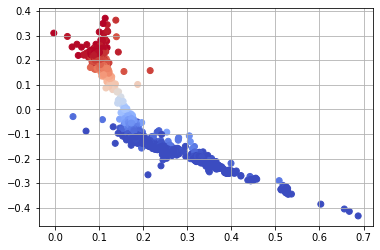

In [47]:
plt.scatter(Z_train[:,0], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.grid()

In [106]:
from scipy.spatial.distance import cdist

np.mean(cdist(Z_train,Z_train))

0.1878608103525254

[-1  0  1  2  3  4  5  6  7  8]


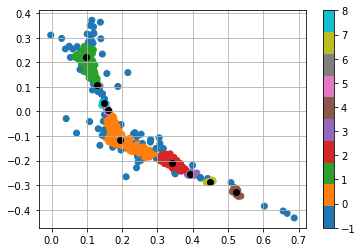

In [127]:
#from sklearn.cluster import OPTICS
#clustering = OPTICS(min_samples=0.03).fit(Z_train)
#labels = clustering.labels_
#np.unique(clustering.labels_)

from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.01, min_samples=5).fit(Z_train)
labels = clustering.labels_
print(np.unique(clustering.labels_))
centers = []
for c in np.unique(clustering.labels_)[1:]:
    centers.append(np.mean(Z_train[clustering.labels_==c],axis=0))
centers = np.stack(centers)
plt.scatter(Z_train[:,0], Z_train[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.scatter(centers[:,0],centers[:,1],c='k')
plt.grid()

In [140]:
from scipy.spatial.distance import cdist

proto = []
for i in range(len(centers)):
    proto.append(X_train[np.argmin(cdist(Z_train,centers[i:i+1,:]))])
proto = np.stack(proto)

In [239]:
from scipy.special import softmax

i = 1
print('X_test', X_test[i:i+1,-1])
print('Z_test', Z_test[i:i+1,:])
print('centers distances', np.round(cdist(Z_test[i:i+1,:],centers),3))
print('proto proba', np.round(proto[:,-1],3))
print(np.sum((1/cdist(Z_test[i:i+1,:],centers))/(np.sum((1/cdist(Z_test[i:i+1,:],centers))))*proto[:,-1]))

X_test [0.00067884]
Z_test [[ 0.191563   -0.11668863]]
centers distances [[0.001 0.35  0.175 0.245 0.391 0.125 0.232 0.307 0.158]]
proto proba [0.002 0.967 0.    0.    0.002 0.326 0.623 0.001 0.419]
0.01427786551254142


In [241]:
proto_pred = np.sum((1/cdist(Z_test[:,:],centers))/(np.sum((1/cdist(Z_test[:,:],centers)),axis=1).reshape(-1,1))*proto[:,-1],axis=1)

In [245]:
accuracy_score(np.round(proto_pred), np.round(X_test[:,-1]))

0.9849737039819685

In [247]:
np.mean(np.abs(proto_pred-X_test[:,-1]))

0.10801402344878441

In [251]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.01, min_samples=5).fit(X_train)
labels = clustering.labels_
print(np.unique(clustering.labels_))
centers = []
for c in np.unique(clustering.labels_)[1:]:
    centers.append(np.mean(X_train[clustering.labels_==c],axis=0))
centers = np.stack(centers)

from scipy.spatial.distance import cdist
proto = []
for i in range(len(centers)):
    proto.append(X_train[np.argmin(cdist(X_train,centers[i:i+1,:]))])
proto = np.stack(proto)
proto_pred = np.sum((1/cdist(X_test[:,:],centers))/(np.sum((1/cdist(X_test[:,:],centers)),axis=1).reshape(-1,1))*proto[:,-1],axis=1)
print(accuracy_score(np.round(proto_pred), np.round(X_test[:,-1])))

[-1  0  1  2  3  4  5  6  7  8  9 10 11]
0.26270974204858505


# Counterfactuals

In [13]:
w = model.fc1.weight.detach().numpy()
b = model.fc1.bias.detach().numpy()
y_contrib = model.fc1.weight.detach().numpy()[:,-1]

In [14]:
def compute_cf(q, indexes):
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=True)
    q_cf = q.copy()
    q_cf_preds = []
    q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
    if q_pred > 0.5:
        m = -0.1
    else:
        m = +0.1
    while np.round(q_pred) == np.round(q_cf_preds[-1]):
        v = np.array(model(torch.tensor(q_cf).float()).detach().numpy()+m*y_contrib)
        c_l = [v[l] - np.sum(q_cf*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        q_cf[indexes] += delta_i
        #q_cf = np.clip(q_cf,-1,1)
        if float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)) in q_cf_preds:
            return q_cf
        q_cf_preds.append(float(predict(q_cf[:-1].reshape(1,-1),return_proba=True)))
        q_cf[-1] = q_cf_preds[-1]
    return q_cf

In [17]:
from itertools import combinations
from scipy.spatial.distance import cdist

d_dist = []
d_impl = []
d_count = []
d_adv = []
num = []
div_dist = []
div_count = []

n = 1

for idx in tqdm(range(n)):
    q = X_test[idx,:].copy()
    q_pred = predict(q[:-1].reshape(1,-1),return_proba=False)
    q_cfs = []
    l_i = []
    l_f = []

    for indexes in list(combinations(list(range(X_train.shape[1]-1)),1)):    
        print(indexes)
        q_cf = compute_cf(q, list(indexes))
        q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
        if q_pred:
            if q_cf_pred<0.5:
                q_cfs.append(q_cf)
        else:
            if q_cf_pred>0.5:
                q_cfs.append(q_cf) 

    for indexes in list(combinations(list(range(X_train.shape[1]-1)),2)):    
        print(indexes)
        q_cf = compute_cf(q, list(indexes))
        q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
        if q_pred:
            if q_cf_pred<0.5:
                q_cfs.append(q_cf)
        else:
            if q_cf_pred>0.5:
                q_cfs.append(q_cf) 
        l_i.append([list(indexes),q_cf_pred])
    r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
    l_i = np.array(l_i,dtype=object)[r,0]

    while len(l_i[0])<2:
        for e in l_i:
            print(e)
            for i in list(np.delete(range(X_train.shape[1]-1),e)):
                q_cf = compute_cf(q, e+[i])
                q_cf_pred = predict(q_cf[:-1].reshape(1,-1),return_proba=True)
                if q_pred:
                    if q_cf_pred<0.5:
                        q_cfs.append(q_cf)
                else:
                    if q_cf_pred>0.5:
                        q_cfs.append(q_cf) 
                l_f.append([e+[i],q_cf_pred])
        r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
        l_f = np.array(l_f,dtype=object)[r,0]
        l_i = l_f.copy()
        l_f = []
    
    if len(q_cfs)<1:
        continue
    else:
        q_cfs = np.vstack(q_cfs)
        d_dist.append(np.min(cdist(q_cfs[:,58:-1],q[58:-1].reshape(1,-1),metric='hamming') + cdist(q_cfs[:,:58],q[:58].reshape(1,-1),metric='euclidean')))
        d_count.append(np.min(np.sum(q_cfs[:,:-1]!=q[:-1],axis=1)))
        d_impl.append(np.min(cdist(q_cfs[:,58:-1],X_train[:,58:-1],metric='hamming') + cdist(q_cfs[:,:58],X_train[:,:58],metric='euclidean')))
        r = np.argsort(cdist(q_cfs[:,58:-1],X_train[:,58:-1],metric='hamming') + cdist(q_cfs[:,:58],X_train[:,:58],metric='euclidean'),axis=1)[:,:10]
        d_adv.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==q_pred) for i in range(q_cfs.shape[0])])))
        num.append(len(q_cfs))
        div_dist.append(np.mean(cdist(q_cfs[:,58:-1],q_cfs[:,58:-1],metric='hamming') + cdist(q_cfs[:,:58],q_cfs[:,:58],metric='euclidean')))
        div_count.append(X_train.shape[1]-1/(q_cfs.shape[0]**2)*np.sum(cdist(q_cfs[:,:-1], q_cfs[:,:-1],metric='hamming')))

  0%|          | 0/1 [00:00<?, ?it/s]

(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)
(16,)
(17,)
(18,)
(19,)
(20,)
(21,)
(22,)
(23,)
(24,)
(25,)
(26,)
(27,)
(28,)
(29,)
(30,)
(31,)
(32,)
(33,)
(34,)
(35,)
(36,)
(37,)
(38,)
(39,)
(40,)
(41,)
(42,)
(43,)
(44,)
(45,)
(46,)
(47,)
(48,)
(49,)
(50,)
(51,)
(52,)
(53,)
(54,)
(55,)
(56,)
(57,)
(58,)
(59,)
(60,)
(61,)
(62,)
(63,)
(64,)
(65,)
(66,)
(67,)
(68,)
(69,)
(70,)
(71,)
(72,)
(73,)
(74,)
(75,)
(76,)
(77,)
(78,)
(79,)
(80,)
(81,)
(82,)
(83,)
(84,)
(85,)
(86,)
(87,)
(88,)
(89,)
(90,)
(91,)
(92,)
(93,)
(94,)
(95,)
(96,)
(97,)
(98,)
(99,)
(100,)
(101,)
(102,)
(103,)
(104,)
(105,)
(106,)
(107,)
(108,)
(109,)
(110,)
(111,)
(112,)
(113,)
(114,)
(115,)
(116,)
(117,)
(118,)
(119,)
(120,)
(121,)
(122,)
(123,)
(124,)
(125,)
(126,)
(127,)
(128,)
(129,)
(130,)
(131,)
(132,)
(133,)
(134,)
(135,)
(136,)
(137,)
(138,)
(139,)
(140,)
(141,)
(142,)
(143,)
(144,)
(145,)
(146,)
(147,)
(148,)
(149,)
(150,)
(151,)
(152,)
(153,)
(154,)
(155,)
(156,)
(157,)
(158

In [18]:
print('d_dist: \t',    np.round(np.mean(d_dist),5),   np.round(np.std(d_dist),5))
print('d_count: \t',   np.round(np.mean(d_count),5),  np.round(np.std(d_count),5))
print('implicity: \t', np.round(np.mean(d_impl),5),   np.round(np.std(d_impl),5))
print('d_adv: \t\t',   np.round(np.mean(d_adv),5),   np.round(np.std(d_adv),5))
print('number: \t',    np.round(np.mean(num),5), np.round(np.std(num),5))
print('div_dist: \t',  np.round(np.mean(div_dist),5), np.round(np.std(div_dist),5))
print('div_count: \t', np.round(np.mean(div_count),5),np.round(np.std(div_count),5))
print('success_rate: \t', len(d_dist)/n)

d_dist: 	 0.00215 0.0
d_count: 	 1.0 0.0
implicity: 	 0.03967 0.0
d_adv: 		 0.47139 0.0
number: 	 5326.0 0.0
div_dist: 	 3.72515 0.0
div_count: 	 524.99248 0.0
success_rate: 	 1.0


In [24]:
q_cfs.shape

(5326, 525)

In [23]:
pd.DataFrame(q,columns=[list(df.columns)+'pred'])

TypeError: can only concatenate list (not "str") to list

In [ ]:
# Growing Sphere

from growingspheres import counterfactuals as cf

d_dist_GS = []
d_count_GS = []
d_impl_GS = []
d_adv_GS = []

for idx in tqdm(range(n)):
    q = X_test[idx,:-1].reshape(1,-1).copy()
    pred = int(predict(q))
    CF = cf.CounterfactualExplanation(q, predict, method='GS')
    CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=False)
    q_cf_GS = CF.enemy
    d_dist_GS.append(float(cdist(q_cf_GS[58:].reshape(1,-1),q[:,58:],metric='hamming') + cdist(q_cf_GS[:58].reshape(1,-1),q[:,:58],metric='euclidean')))
    d_count_GS.append(np.sum(q_cf_GS!=q))
    d_impl_GS.append(np.min(cdist(q_cf_GS[58:].reshape(1,-1),X_train[:,58:-1],metric='hamming') + cdist(q_cf_GS[:58].reshape(1,-1),X_train[:,:58],metric='euclidean')))
    r = np.argsort(cdist(q_cf_GS[58:].reshape(1,-1),X_train[:,58:-1],metric='hamming') + cdist(q_cf_GS[:58].reshape(1,-1),X_train[:,:58],metric='euclidean'),axis=1)[:,:10]
    d_adv_GS.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==pred) for i in range(q_cf_GS.reshape(1,-1).shape[0])])))

print('d_dist_GS: \t',    np.round(np.mean(d_dist_GS),5),   np.round(np.std(d_dist_GS),5))
print('d_count_GS: \t',   np.round(np.mean(d_count_GS),5),  np.round(np.std(d_count_GS),5))
print('d_impl_GS: \t', np.round(np.mean(d_impl_GS),5),   np.round(np.std(d_impl_GS),5))
print('d_adv_GS: \t',   np.round(np.mean(d_adv_GS),5),   np.round(np.std(d_adv_GS),5))
print('success_rate: \t', len(d_dist_GS)/n)

d_dist_GS: 	 0.69118 0.0
d_count_GS: 	 4.0 0.0
d_impl_GS: 	 0.61086 0.0
d_adv_GS: 	 1.0 0.0


In [ ]:
# Watcher

from scipy.spatial.distance import cdist, euclidean
from scipy.optimize import minimize
from scipy import stats

d_dist_watch = []
d_count_watch = []
d_impl_watch = []
d_adv_watch = []

for idx in tqdm(range(100)):
    # initial conditions
    lamda = 0.1 
    x0 = np.zeros([1,X_train.shape[1]-1]) # initial guess for cf
    q = X_test[idx:idx+1,:-1].copy()
    pred = predict(q,return_proba=False)

    def dist_mad(cf, eg):
        manhat = [cdist(eg.T, cf.reshape(1,-1).T ,metric='cityblock')[i][i] for i in range(len(eg.T))]
        #mad = stats.median_absolute_deviation(X_train)
        return sum(manhat)

    def loss_function_mad(x_dash):
        target = 1-pred
        if target == 0:
            L = lamda*(predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q)
        else:
            L = lamda*(1-predict(x_dash.reshape(1,-1),return_proba=True)-1)**2 + dist_mad(x_dash.reshape(1,-1), q) 
        return L

    res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
    cf = res.x.reshape(1, -1)

    i = 0
    r = 1
    while pred == predict(cf):
        lamda += 0.1
        x0 = cf 
        res = minimize(loss_function_mad, x0, method='nelder-mead', options={'maxiter':100, 'xatol': 1e-6})
        cf = res.x.reshape(1, -1)
        i += 1
        if i == 100:
            r = 0
            break

    if r == 1:
        d_dist_watch.append(float(cdist(cf[:,58:],q[:,58:],metric='hamming') + cdist(cf[:,:58],q[:,:58],metric='euclidean')))
        d_count_watch.append(np.sum(q_cf_GS!=q))
        d_impl_watch.append(np.min(cdist(cf[:,58:],X_train[:,58:-1],metric='hamming') + cdist(cf[:,:58],X_train[:,:58],metric='euclidean')))
        r = np.argsort(cdist(cf[:,58:],X_train[:,58:-1],metric='hamming') + cdist(cf[:,:58],X_train[:,:58],metric='euclidean'),axis=1)[:,:10]
        d_adv_watch.append(np.mean(np.array([np.mean(predict(X_train[r,:-1][i,:])==pred) for i in range(q_cf_GS.reshape(1,-1).shape[0])])))

print('d_dist_watch: \t',    np.round(np.mean(d_dist_watch),5),   np.round(np.std(d_dist_watch),5))
print('d_count_watch: \t',   np.round(np.mean(d_count_watch),5),  np.round(np.std(d_count_watch),5))
print('d_impl_watch: \t', np.round(np.mean(d_impl_watch),5),   np.round(np.std(d_impl_watch),5))
print('d_adv_watch: \t',   np.round(np.mean(d_adv_watch),5),   np.round(np.std(d_adv_watch),5))
print('success_rate: \t', len(d_dist_watch)/n)

d_dist_watch: 	 2.61927 0.0
d_count_watch: 	 7.0 0.0
d_impl_watch: 	 1.78204 0.0
d_adv_watch: 	 0.0 0.0


In [123]:
q = np.hstack((q[0,:],predict(q.reshape(1,-1),return_proba=True))).reshape(1,-1)
q_cfs[:,2:] = np.round(q_cfs[:,2:])
q_cfs[:,-1] = predict(q_cfs[:,:-1],return_proba=True)
q_cf_GS = q_cf_GS.reshape(1,-1)
q_cf_GS[:,2:] = np.round(q_cf_GS[:,2:])
q_cf_GS = np.hstack((q_cf_GS[0,:],predict(q_cf_GS,return_proba=True)))
q_cf = q_cf.reshape(1,-1)
q_cf[:,2:] = np.round(q_cf[:,2:])
q_cf[:,-1] = predict(q_cf[:,:-1],return_proba=True)

In [172]:
indexes = [20,21,24,76,122]
df_res = pd.DataFrame(np.vstack([q,q_cfs[indexes,:],q_cf_GS,q_cf]),
            index=['q']+[f'q_cf_latent_{i}' for i in range(len(q_cfs[indexes,:]))]+['q_cf_GS','q_cf_wach'], 
            columns=df.columns)
df_res

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
q,-0.150685,0.000000,5.0,0.0,2.0,1.0,1.0,0.754399
q_cf_latent_0,-0.150685,0.000000,5.0,1.0,2.0,1.0,1.0,0.350119
q_cf_latent_1,-0.150685,0.000000,5.0,1.0,2.0,0.0,1.0,0.281171
q_cf_latent_2,-0.150685,0.000000,5.0,0.0,-0.0,1.0,4.0,0.192105
q_cf_latent_3,-0.383117,0.000000,5.0,1.0,2.0,1.0,1.0,0.342701
q_cf_latent_4,-0.315358,-0.263194,5.0,1.0,1.0,1.0,1.0,0.310576
q_cf_GS,-0.150685,-0.091183,6.0,0.0,2.0,1.0,1.0,0.185908
q_cf_wach,-0.337704,-0.243003,5.0,1.0,2.0,1.0,1.0,0.337644
q_cf_dice_0,-0.150685,0.000000,1.0,0.0,5.0,1.0,1.0,0.318463
q_cf_dice_1,-0.150685,0.084957,6.0,0.0,2.0,1.0,1.0,0.186686


In [206]:
df_res.loc[:,'age'] = df_res.loc[:,'age'].replace({-0.15068493:48,-0.15068493150684947:48,-0.38311740936562505:40, -0.31535755498186513:42, -0.3377037522600478:41})
df_res.loc[:,'hoursPerWeek'] = df_res.loc[:,'hoursPerWeek'].replace({0:50,-0.26319398100559593:37.10,-0.09118255513392676:45.53,-0.24300260389071077:38.09,0.08495728:54.16})
df_res.loc[:,'education'] = df_res.loc[:,'education'].replace({5:'ProfSchool',6:'Dropout',1:'CommunityCollege'})
df_res.loc[:,'marital_status'] = df_res.loc[:,'marital_status'].replace({0:'Married',1:'NotMarried'})
df_res.loc[:,'occupation'] = df_res.loc[:,'occupation'].replace({2:'ProfSpecialty',0:'BlueCollar',1:'ExecManagerial',5:'Services'})
df_res.loc[:,'gender'] = df_res.loc[:,'gender'].replace({0:'Female',1:'Male'})
df_res.loc[:,'native_country'] = df_res.loc[:,'native_country'].replace({4:'US',1:'US'})
df_res

,age,hoursPerWeek,education,marital_status,occupation,gender,native_country,income
q,48.0,50.00,ProfSchool,Married,ProfSpecialty,Male,US,0.754399
q_cf_latent_0,48.0,50.00,ProfSchool,NotMarried,ProfSpecialty,Male,US,0.350119
q_cf_latent_1,48.0,50.00,ProfSchool,NotMarried,ProfSpecialty,Female,US,0.281171
q_cf_latent_2,48.0,50.00,ProfSchool,Married,BlueCollar,Male,US,0.192105
q_cf_latent_3,40.0,50.00,ProfSchool,NotMarried,ProfSpecialty,Male,US,0.342701
q_cf_latent_4,42.0,37.10,ProfSchool,NotMarried,ExecManagerial,Male,US,0.310576
q_cf_GS,48.0,45.53,Dropout,Married,ProfSpecialty,Male,US,0.185908
q_cf_wach,41.0,38.09,ProfSchool,NotMarried,ProfSpecialty,Male,US,0.337644
q_cf_dice_0,48.0,50.00,CommunityCollege,Married,Services,Male,US,0.318463
q_cf_dice_1,48.0,54.16,Dropout,Married,ProfSpecialty,Male,US,0.186686


In [ ]:
#ord_enc
#array(['Bachelors', 'CommunityCollege', 'Doctorate', 'HighGrad','Masters', 'ProfSchool', 'dropout']),
#array(['married', 'notmarried']),
#array(['BlueCollar', 'ExecManagerial', 'ProfSpecialty', 'Sales', 'Services']),
#array(['Female', 'Male']),
#array(['Non_US', 'United-States'])

In [ ]:
#std
#[[48.00000006 50.        ]
# [39.5162295  50.        ]
# [41.989433   37.103494  ]
# [47.9999975  45.532033  ]
# [41.173804   38.092853  ]
# [48.00000006 54.16290672]]